In [1]:
import torch
print(torch.__version__)

2.6.0+cu126


## Вспомогательные структуры из блокнота к предыдущей лекции

In [2]:
from torchvision import datasets

download_dir = "./dataset"

train_data = datasets.STL10(root=download_dir, download=True, split="train")
val_data = datasets.STL10(root=download_dir, download=True, split="test")

x_train = torch.tensor(train_data.data) / 255.
y_train = torch.tensor(train_data.labels)

x_val = torch.tensor(val_data.data) / 255.
y_val = torch.tensor(val_data.labels)

In [4]:
classes_ru = [
    "самолёт",
    "птица",
    "машина",
    "кошка",
    "олень",
    "собака",
    "лошадь",
    "обезьяна",
    "корабль",
    "грузовик",
]

## Аугментация и нормализация данных с помощью transforms 

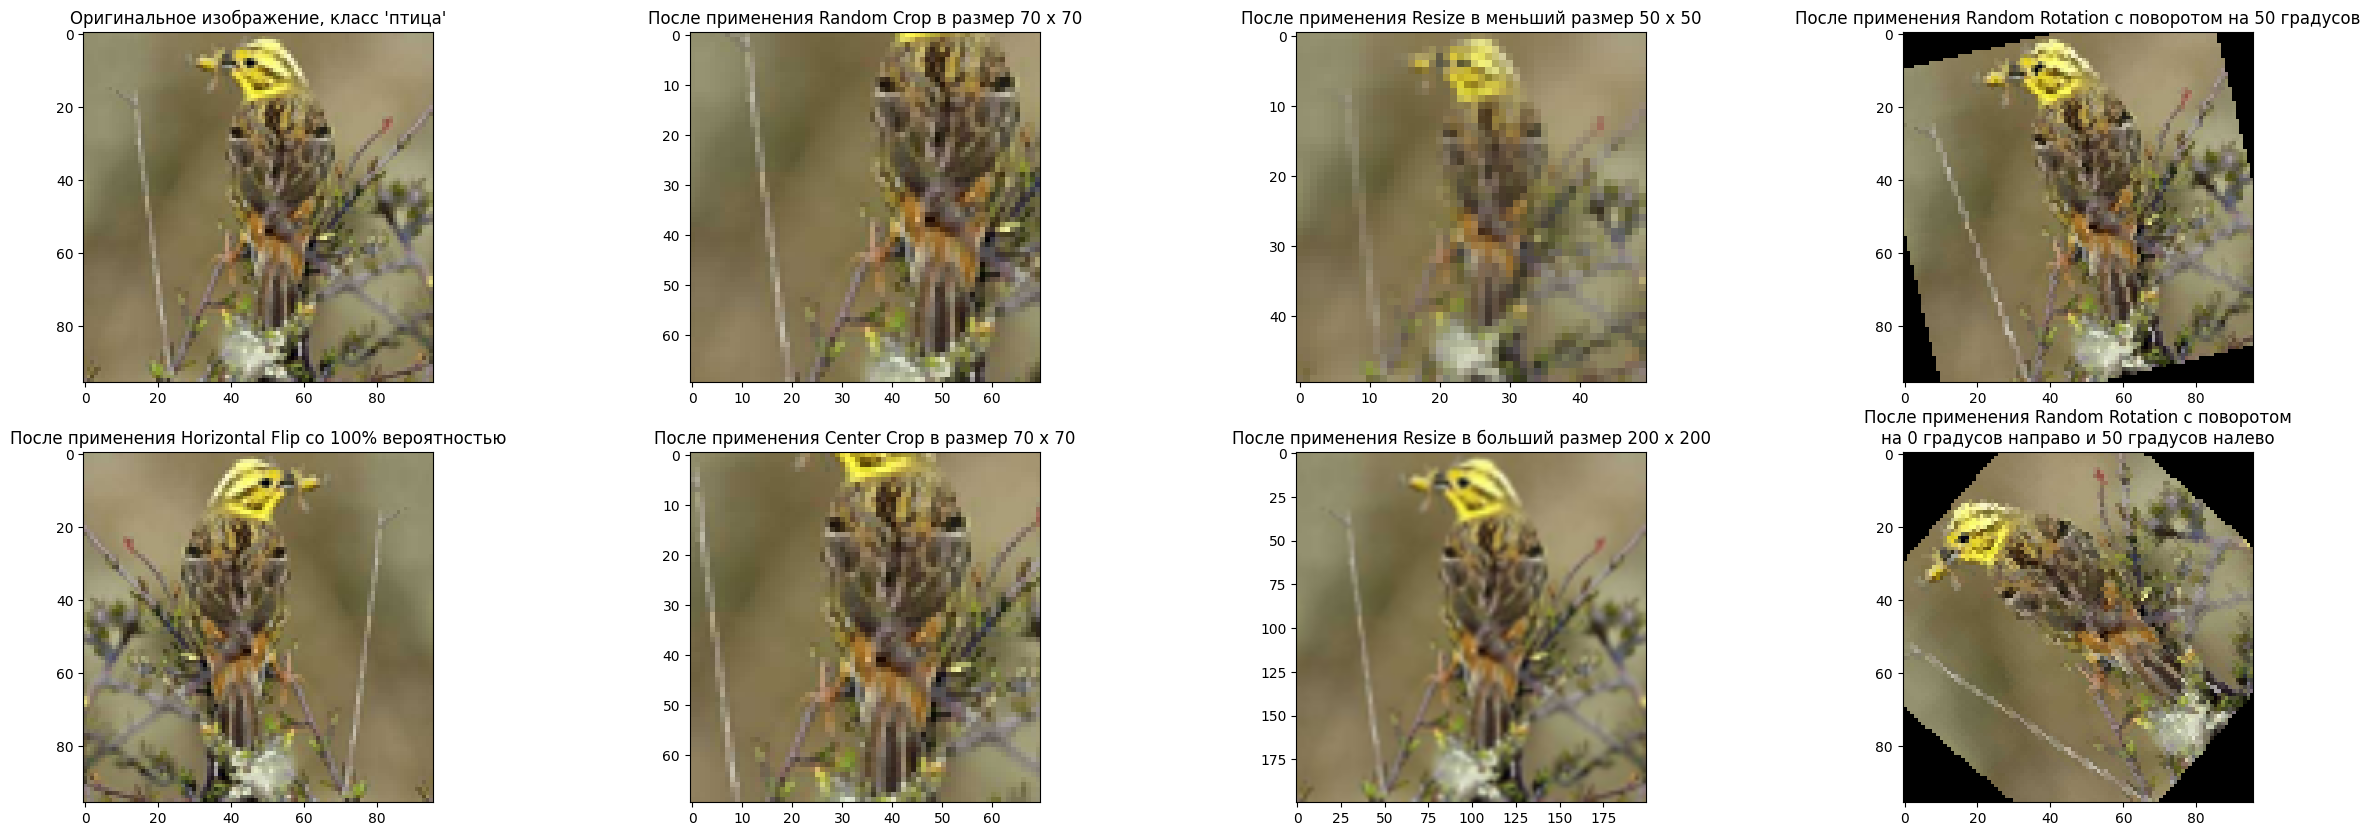

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import transforms  # В библиотеке можно найти много различных аугментаций.

img_ind = 0

img = transforms.ToPILImage()(x_train[img_ind])  # PilImage — один из форматов хранения изображений в Python.

fig, ax = plt.subplots(2, 4, figsize=(30, 10))
plt.subplot(241)
plt.imshow(img)
plt.title(f"Оригинальное изображение, класс '{classes_ru[y_train[img_ind]]}'")

plt.subplot(245)
plt.imshow(transforms.RandomHorizontalFlip(1.)(img))
plt.title("После применения Horizontal Flip со 100% вероятностью")

plt.subplot(242)
plt.imshow(transforms.RandomCrop((70, 70))(img))
plt.title("После применения Random Crop в размер 70 x 70")

plt.subplot(246)
plt.imshow(transforms.CenterCrop((70, 70))(img))
plt.title("После применения Center Crop в размер 70 x 70")

plt.subplot(243)
plt.imshow(transforms.Resize((50, 50))(img))
plt.title("После применения Resize в меньший размер 50 x 50")

plt.subplot(247)
plt.imshow(transforms.Resize((200, 200))(img))
plt.title("После применения Resize в больший размер 200 x 200")

plt.subplot(244)
plt.imshow(transforms.RandomRotation(50)(img))
plt.title("После применения Random Rotation с поворотом на 50 градусов")

plt.subplot(248)
plt.imshow(transforms.RandomRotation((0, 50))(img))
plt.title("После применения Random Rotation с поворотом\nна 0 градусов направо и 50 градусов налево")

plt.show()

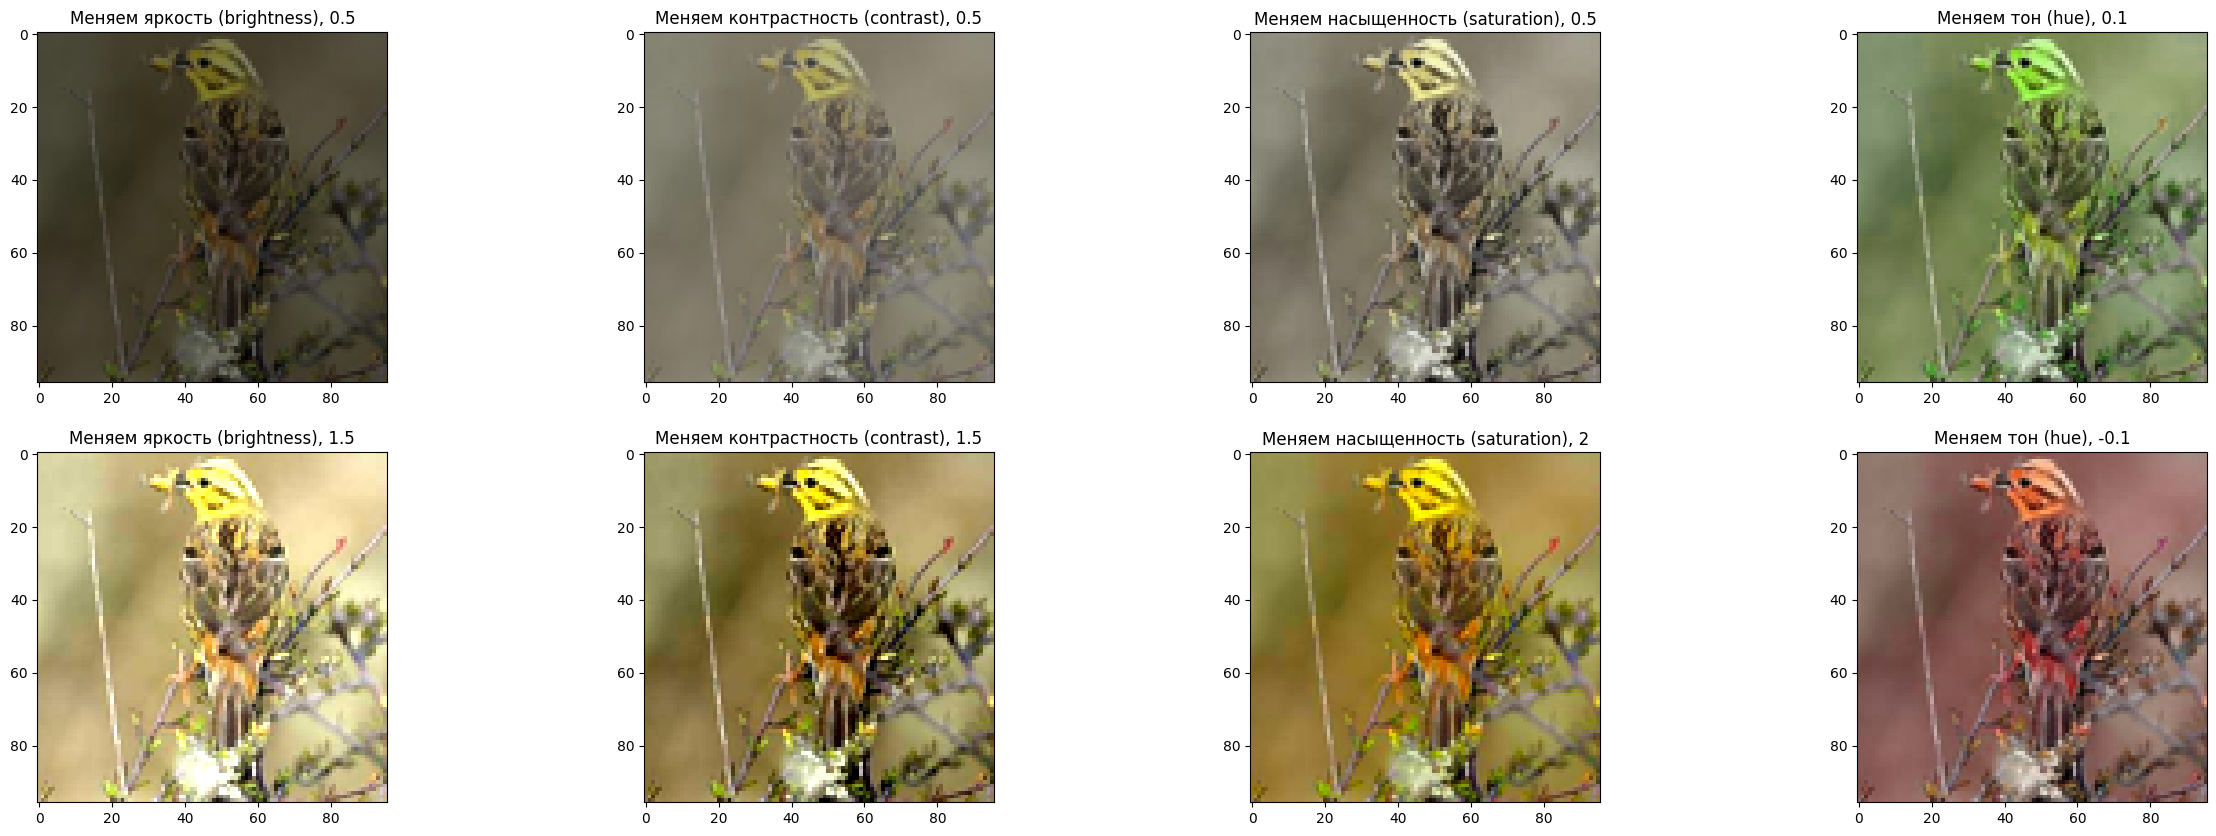

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10))

plt.subplot(241)
plt.imshow(transforms.ColorJitter(brightness=(0.5, 0.5))(img))
plt.title(f"Меняем яркость (brightness), 0.5")

plt.subplot(245)
plt.imshow(transforms.ColorJitter(brightness=(1.5, 1.5))(img))
plt.title("Меняем яркость (brightness), 1.5")

plt.subplot(242)
plt.imshow(transforms.ColorJitter(contrast=(0.5, 0.5))(img))
plt.title("Меняем контрастность (contrast), 0.5")

plt.subplot(246)
plt.imshow(transforms.ColorJitter(contrast=(1.5, 1.5))(img))
plt.title("Меняем контрастность (contrast), 1.5")

plt.subplot(243)
plt.imshow(transforms.ColorJitter(saturation=(0.5, 0.5))(img))
plt.title("Меняем насыщенность (saturation), 0.5")

plt.subplot(247)
plt.imshow(transforms.ColorJitter(saturation=(2, 2))(img))
plt.title("Меняем насыщенность (saturation), 2")

plt.subplot(244)
plt.imshow(transforms.ColorJitter(hue=(0.1, 0.1))(img))
plt.title("Меняем тон (hue), 0.1")

plt.subplot(248)
plt.imshow(transforms.ColorJitter(hue=(-0.1, -0.1))(img))
plt.title("Меняем тон (hue), -0.1")

plt.show()

In [7]:
# Добавим аугментации на уровне датасета.
class AddTransformsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index: int):
        image = self.x[index]
        if self.transforms is not None:
            image = self.transforms(image)
        return image, self.y[index]

In [8]:
# Среднее и отклонение по каналам.
channel_mean = x_train.mean((0, 2, 3))
channel_std = x_train.std((0, 2, 3))

# Группа преобразований за раз (работает как torch.nn.Sequential, но для аугментаций).
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

# Операция, обратная нормализации.
def de_normalize(img):
    return (img * channel_std[:, None, None] + channel_mean[:, None, None]).permute(1, 2, 0)

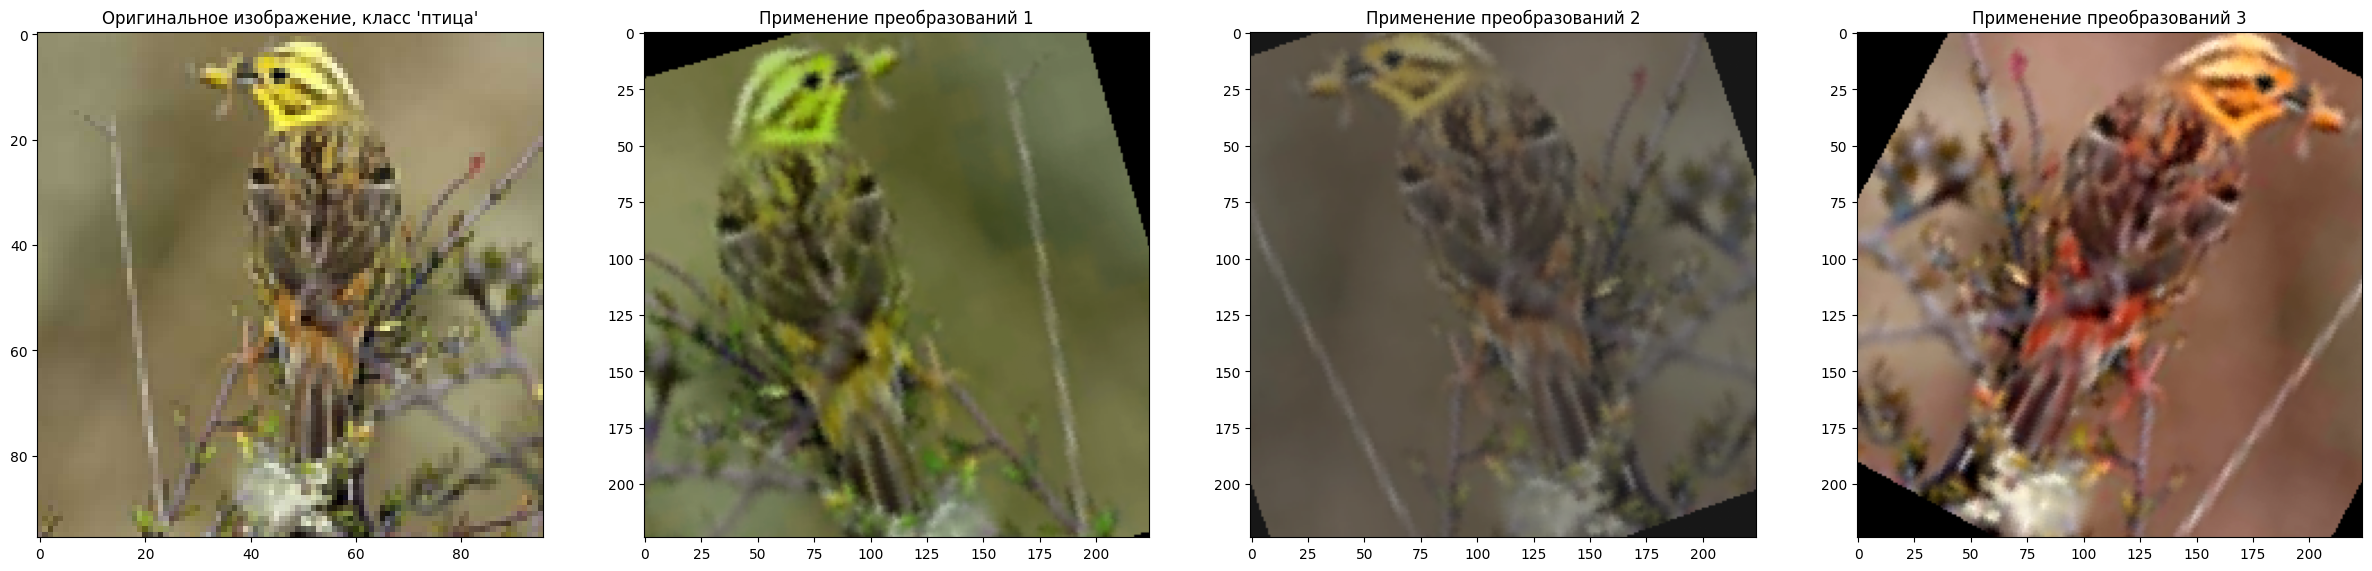

In [9]:
img_ind = 0

img = x_train[img_ind]

fig, ax = plt.subplots(1, 4, figsize=(30, 10))
plt.subplot(141)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Оригинальное изображение, класс '{classes_ru[y_train[img_ind]]}'")

plt.subplot(142)
plt.imshow(de_normalize(train_transforms(img)), vmin=0., vmax=1.)
plt.title("Применение преобразований 1")

plt.subplot(143)
plt.imshow(de_normalize(train_transforms(img)), vmin=0., vmax=1.)
plt.title("Применение преобразований 2")

plt.subplot(144)
plt.imshow(de_normalize(train_transforms(img)), vmin=0., vmax=1.)
plt.title("Применение преобразований 3")

plt.show()

In [10]:
# Для валидации мы хотим меньше случайных преобразований.
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

In [12]:
# Получим датасеты и даталоадеры
train_dataset = AddTransformsDataset(x_train, y_train, train_transforms)
val_dataset = AddTransformsDataset(x_val, y_val, val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,  # Датасет (обязательно в формате torch.utils.data.Dataset).
    batch_size=200,         # Размер батча.
    shuffle=True,           # Перемешивать ли данные при формировании даталоадера.
    drop_last=True,         # Если не хватает объектов для полного батча, то выкинуть ли такой батч.
    num_workers=8,          # Сколько CPU использовать для подсчёта данных.
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,  # Датасет (обязательно в формате torch.utils.data.Dataset).
    batch_size=200,       # Размер батча.
    shuffle=False,        # Перемешивать ли данные при формировании даталоадера.
    drop_last=False,      # Если не хватает объектов для полного батча, то выкинуть ли такой батч.
    num_workers=8,        # Сколько CPU использовать для подсчёта данных.
)

In [21]:
img = torch.load(f"bird_transformed.pt")

In [22]:
# Группа преобразований за раз (работает как torch.nn.Sequential, но для аугментаций).
train_transforms = transforms.Compose([
    transforms.ToPILImage(),

    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

Text(0.5, 1.0, 'Применение преобразований 1')

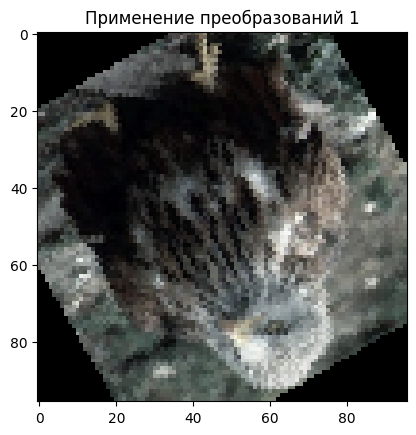

In [23]:
plt.imshow(de_normalize(train_transforms(img)), vmin=0., vmax=1.)
plt.title("Применение преобразований 1")